In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [30]:
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')

In [31]:
X = train_features.drop(columns=['respondent_id'])
y_xyz = train_labels['xyz_vaccine']
y_seasonal = train_labels['seasonal_vaccine']
X_test = test_features.drop(columns=['respondent_id'])

In [32]:
X_train, X_val, y_train_xyz, y_val_xyz = train_test_split(X, y_xyz, test_size=0.25, random_state=42)
_, _, y_train_seasonal, y_val_seasonal = train_test_split(X, y_seasonal, test_size=0.25, random_state=42)

In [33]:
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

In [34]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [35]:
model_xyz = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
model_seasonal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [36]:
model_xyz.fit(X_train, y_train_xyz)
model_seasonal.fit(X_train, y_train_seasonal)
y_pred_xyz_val = model_xyz.predict_proba(X_val)[:, 1]
y_pred_seasonal_val = model_seasonal.predict_proba(X_val)[:, 1]

In [37]:
y_pred_xyz = model_xyz.predict_proba(X_test)[:, 1]
y_pred_seasonal = model_seasonal.predict_proba(X_test)[:, 1]

In [38]:
roc_auc_xyz = roc_auc_score(y_val_xyz, y_pred_xyz_val)
roc_auc_seasonal = roc_auc_score(y_val_seasonal, y_pred_seasonal_val)

In [39]:
print(f"ROC AUC for XYZ Vaccine on Validation Set: {roc_auc_xyz}")
print(f"ROC AUC for Seasonal Vaccine on Validation Set: {roc_auc_seasonal}")

ROC AUC for XYZ Vaccine on Validation Set: 0.8613296312296905
ROC AUC for Seasonal Vaccine on Validation Set: 0.8578159027159964


In [40]:
fpr_xyz, tpr_xyz, _ = roc_curve(y_val_xyz, y_pred_xyz_val)
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val_seasonal, y_pred_seasonal_val)

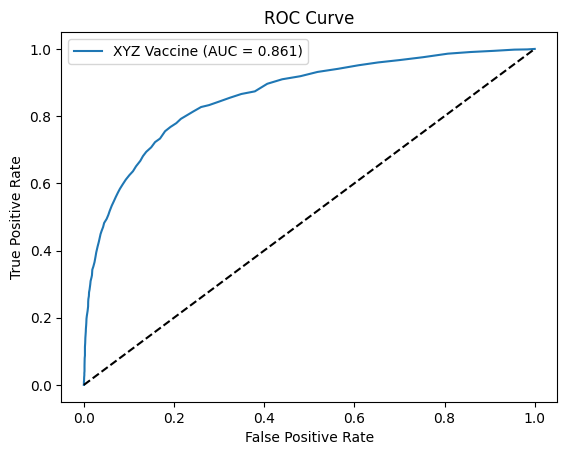

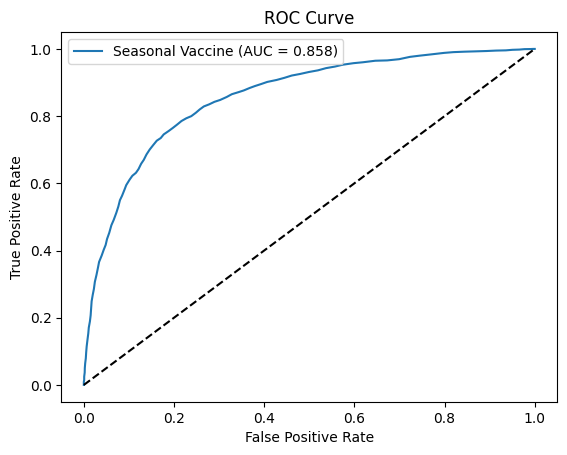

In [46]:
plt.figure()
plt.plot(fpr_xyz, tpr_xyz, label=f"XYZ Vaccine (AUC = {roc_auc_xyz:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(fpr_seasonal, tpr_seasonal, label=f"Seasonal Vaccine (AUC = {roc_auc_seasonal:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [43]:
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': y_pred_xyz,
    'seasonal_vaccine': y_pred_seasonal
})
submission.to_csv('submission.csv', index=False)